In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import os

# Suppress TensorFlow warnings for cleaner output
tf.keras.utils.disable_interactive_logging()

In [ ]:
# --- Part 1: Dataset Loading and Preprocessing ---

print("--- Part 1: Loading and Preprocessing the MNIST Dataset ---")

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# The shape of the images is (28, 28). We need to reshape them to (28, 28, 1)
# to add a channel dimension, which is required for convolutional layers.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Normalize the pixel values to be in the range [-1, 1].
# This is a common practice for GANs and helps with training stability.
# The `tanh` activation function in the generator's output layer works well with this range.
x_train = (x_train - 127.5) / 127.5

print(f"Normalized training data shape: {x_train.shape}")
print("Example of a normalized pixel value:", x_train[0, 0, 0, 0])


--- Part 1: Loading and Preprocessing the MNIST Dataset ---
Normalized training data shape: (60000, 28, 28, 1)
Example of a normalized pixel value: -1.0


In [ ]:
# --- Part 2: Building the Generator and Discriminator Models ---

print("\n--- Part 2: Building the GAN Components ---")

# The size of the random noise vector (latent space dimension)
latent_dim = 100

# 1. The Generator Model
# The Generator takes a 100-dimensional noise vector and generates a 28x28x1 image.
def build_generator():
    model = keras.Sequential(name="generator")
    # Project the noise vector to a large enough space for upsampling
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    # Batch Normalization helps stabilize training
    model.add(layers.BatchNormalization())
    # Leaky ReLU is used as activation to prevent 'dying ReLU' problem
    model.add(layers.LeakyReLU())

    # Reshape the vector to a 2D grid with a high number of channels
    model.add(layers.Reshape((7, 7, 256)))

    # Use Conv2DTranspose (deconvolution) layers to upsample the image
    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final output layer: 1 channel (grayscale) and tanh activation to scale
    # the output to the [-1, 1] range, matching our normalized training data.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
print("\n--- Generator Model Summary ---")
generator.summary()


--- Part 2: Building the GAN Components ---

--- Generator Model Summary ---


In [ ]:
# 2. The Discriminator Model
# The Discriminator is a binary classifier that takes a 28x28x1 image and
# outputs a single probability of it being a real image.
def build_discriminator():
    model = keras.Sequential(name="discriminator")
    # Use Conv2D layers to downsample and extract features from the image.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # Dropout is used to prevent overfitting
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output to feed into a dense layer
    model.add(layers.Flatten())
    # Output layer with sigmoid activation for binary classification (real vs. fake)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
print("\n--- Discriminator Model Summary ---")
discriminator.summary()


--- Discriminator Model Summary ---


In [ ]:
# --- Part 3: Defining Loss Functions, Optimizers, and the Training Loop ---

# This section sets up the training process for the GAN.

# 1. Loss and Optimizers
# Binary Cross-entropy is the standard loss function for GANs
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

# The Discriminator's loss: real images should be classified as 1, fake as 0.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator's loss: It wants the Discriminator to classify its fake images as 1.
def generator_loss(fake_output):
    # The generator's goal is to make the discriminator's output for fake images
    # as close to 1 as possible.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Use separate optimizers for each network.
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# 2. The Training Step (a single iteration of the adversarial game)
@tf.function
def train_step(images, latent_dim=latent_dim):
    # Generate random noise for the generator
    noise = tf.random.normal([batch_size, latent_dim])

    # Use a `tf.GradientTape` to record operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get the discriminator's output for both real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate the loss for each model
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for each model
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to update the weights of each model
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# 3. Utility function to generate and save images during training
def generate_and_save_images(model, epoch, test_input):
    # Make sure `training` is set to False for inference
    predictions = model(test_input, training=False)
    # The output is in [-1, 1], so we need to rescale it to [0, 1] for plotting.
    predictions_rescaled = (predictions * 0.5) + 0.5

    # Create a figure and subplots for visualization
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Show the image (28x28, grayscale)
        plt.imshow(predictions_rescaled[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}", fontsize=16)

    # Create an `images` directory if it doesn't exist to save the generated images
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
# 4. Training Parameters
EPOCHS = 200
batch_size = 256
# We'll generate a fixed set of noise vectors to track the generator's progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_dim])

# Create a tf.data.Dataset for efficient batching
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)


--- Beginning GAN Training ---
Epoch 1/200 - Generator Loss: 0.7565, Discriminator Loss: 1.0740
Epoch 2/200 - Generator Loss: 0.9486, Discriminator Loss: 1.1223
Epoch 3/200 - Generator Loss: 1.0079, Discriminator Loss: 1.0881
Epoch 4/200 - Generator Loss: 0.8324, Discriminator Loss: 1.2899
Epoch 5/200 - Generator Loss: 0.9411, Discriminator Loss: 1.2309
Epoch 6/200 - Generator Loss: 0.7894, Discriminator Loss: 1.3396
Epoch 7/200 - Generator Loss: 0.8236, Discriminator Loss: 1.2922
Epoch 8/200 - Generator Loss: 0.8017, Discriminator Loss: 1.3115
Epoch 9/200 - Generator Loss: 0.8553, Discriminator Loss: 1.2780
Epoch 10/200 - Generator Loss: 0.8702, Discriminator Loss: 1.2812
Epoch 11/200 - Generator Loss: 0.9370, Discriminator Loss: 1.2172
Epoch 12/200 - Generator Loss: 0.9476, Discriminator Loss: 1.2114
Epoch 13/200 - Generator Loss: 0.9199, Discriminator Loss: 1.2215
Epoch 14/200 - Generator Loss: 0.9942, Discriminator Loss: 1.1962
Epoch 15/200 - Generator Loss: 1.0953, Discriminator 

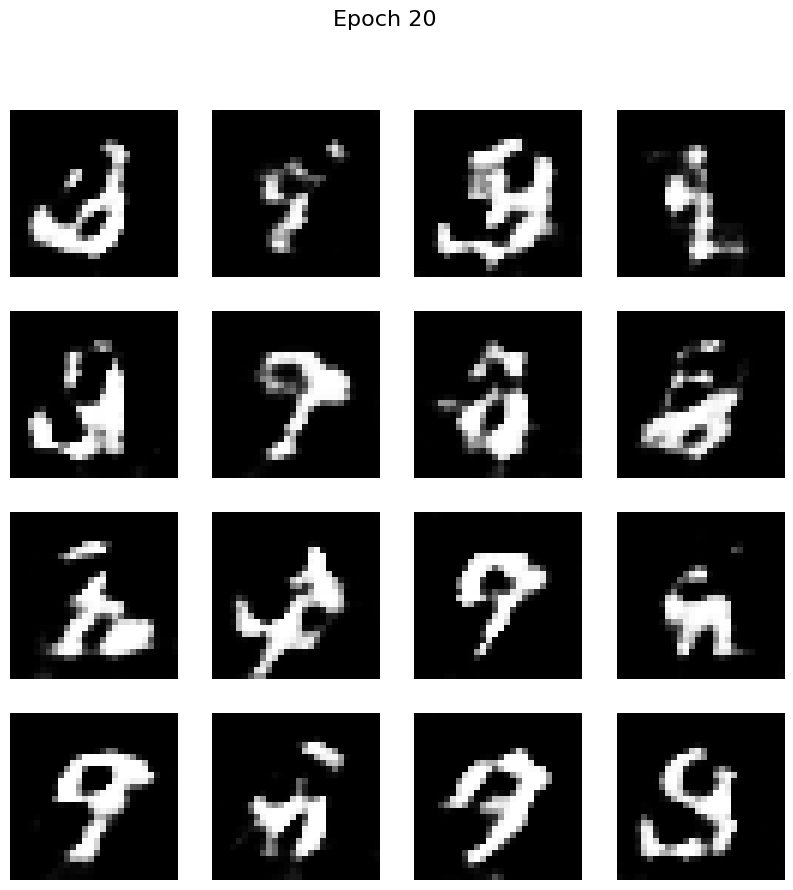

Epoch 21/200 - Generator Loss: 1.1911, Discriminator Loss: 1.0568
Epoch 22/200 - Generator Loss: 1.2252, Discriminator Loss: 1.0240
Epoch 23/200 - Generator Loss: 1.1560, Discriminator Loss: 1.0685
Epoch 24/200 - Generator Loss: 1.2008, Discriminator Loss: 1.0528
Epoch 25/200 - Generator Loss: 1.2095, Discriminator Loss: 1.0734
Epoch 26/200 - Generator Loss: 1.2021, Discriminator Loss: 1.0744
Epoch 27/200 - Generator Loss: 1.1818, Discriminator Loss: 1.0808
Epoch 28/200 - Generator Loss: 1.1681, Discriminator Loss: 1.0952
Epoch 29/200 - Generator Loss: 1.1396, Discriminator Loss: 1.1278
Epoch 30/200 - Generator Loss: 1.0967, Discriminator Loss: 1.1442
Epoch 31/200 - Generator Loss: 1.0954, Discriminator Loss: 1.1520
Epoch 32/200 - Generator Loss: 1.0513, Discriminator Loss: 1.1809
Epoch 33/200 - Generator Loss: 1.0552, Discriminator Loss: 1.1683
Epoch 34/200 - Generator Loss: 1.0387, Discriminator Loss: 1.1783
Epoch 35/200 - Generator Loss: 0.9800, Discriminator Loss: 1.1996
Epoch 36/2

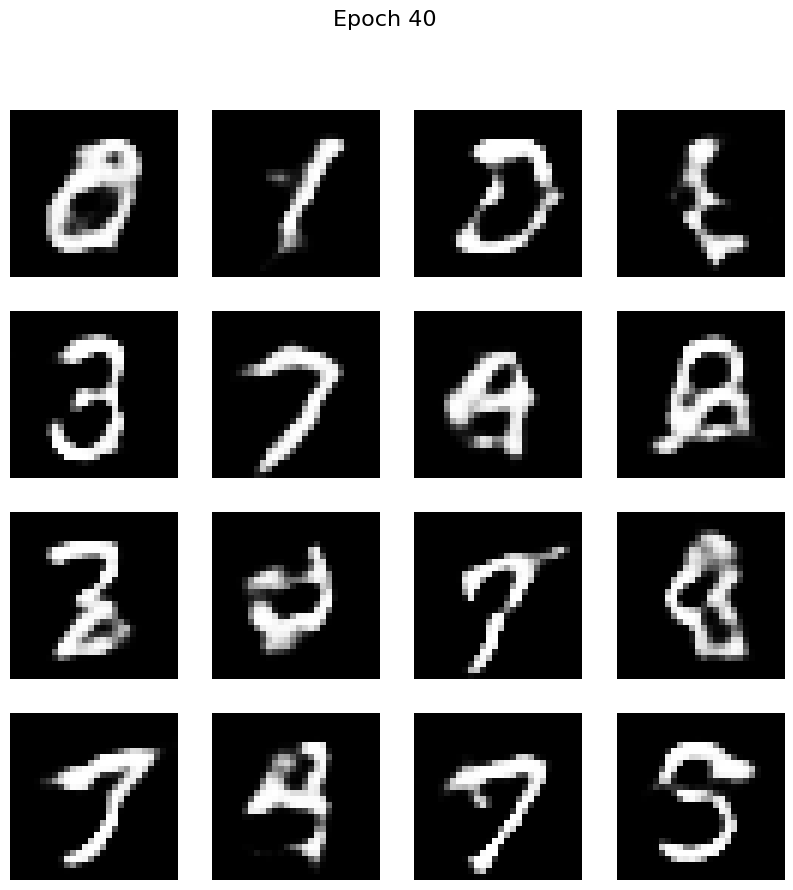

Epoch 41/200 - Generator Loss: 0.9491, Discriminator Loss: 1.2293
Epoch 42/200 - Generator Loss: 0.9452, Discriminator Loss: 1.2329
Epoch 43/200 - Generator Loss: 0.9484, Discriminator Loss: 1.2314
Epoch 44/200 - Generator Loss: 1.0014, Discriminator Loss: 1.2048
Epoch 45/200 - Generator Loss: 0.9847, Discriminator Loss: 1.2064
Epoch 46/200 - Generator Loss: 0.9636, Discriminator Loss: 1.2324
Epoch 47/200 - Generator Loss: 0.9223, Discriminator Loss: 1.2502
Epoch 48/200 - Generator Loss: 0.9091, Discriminator Loss: 1.2453
Epoch 49/200 - Generator Loss: 0.9058, Discriminator Loss: 1.2508
Epoch 50/200 - Generator Loss: 0.9548, Discriminator Loss: 1.2228
Epoch 51/200 - Generator Loss: 1.0095, Discriminator Loss: 1.1956
Epoch 52/200 - Generator Loss: 1.0161, Discriminator Loss: 1.2184
Epoch 53/200 - Generator Loss: 0.9731, Discriminator Loss: 1.2132
Epoch 54/200 - Generator Loss: 0.9405, Discriminator Loss: 1.2384
Epoch 55/200 - Generator Loss: 0.9461, Discriminator Loss: 1.2265
Epoch 56/2

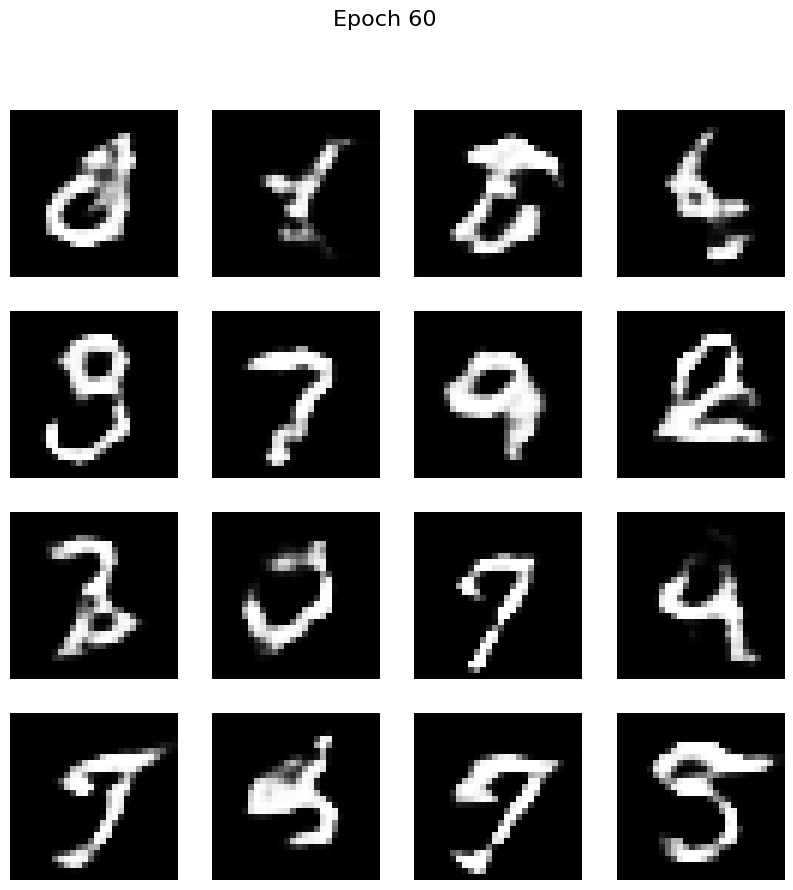

Epoch 61/200 - Generator Loss: 0.9761, Discriminator Loss: 1.2280
Epoch 62/200 - Generator Loss: 0.9807, Discriminator Loss: 1.2072
Epoch 63/200 - Generator Loss: 0.9390, Discriminator Loss: 1.2362
Epoch 64/200 - Generator Loss: 0.9205, Discriminator Loss: 1.2436
Epoch 65/200 - Generator Loss: 0.9239, Discriminator Loss: 1.2360
Epoch 66/200 - Generator Loss: 0.9486, Discriminator Loss: 1.2403
Epoch 67/200 - Generator Loss: 0.9617, Discriminator Loss: 1.2203
Epoch 68/200 - Generator Loss: 0.9293, Discriminator Loss: 1.2394
Epoch 69/200 - Generator Loss: 0.9247, Discriminator Loss: 1.2350
Epoch 70/200 - Generator Loss: 0.9307, Discriminator Loss: 1.2322
Epoch 71/200 - Generator Loss: 0.9459, Discriminator Loss: 1.2477
Epoch 72/200 - Generator Loss: 0.9848, Discriminator Loss: 1.2184
Epoch 73/200 - Generator Loss: 0.9455, Discriminator Loss: 1.2287
Epoch 74/200 - Generator Loss: 0.9166, Discriminator Loss: 1.2361
Epoch 75/200 - Generator Loss: 0.9074, Discriminator Loss: 1.2510
Epoch 76/2

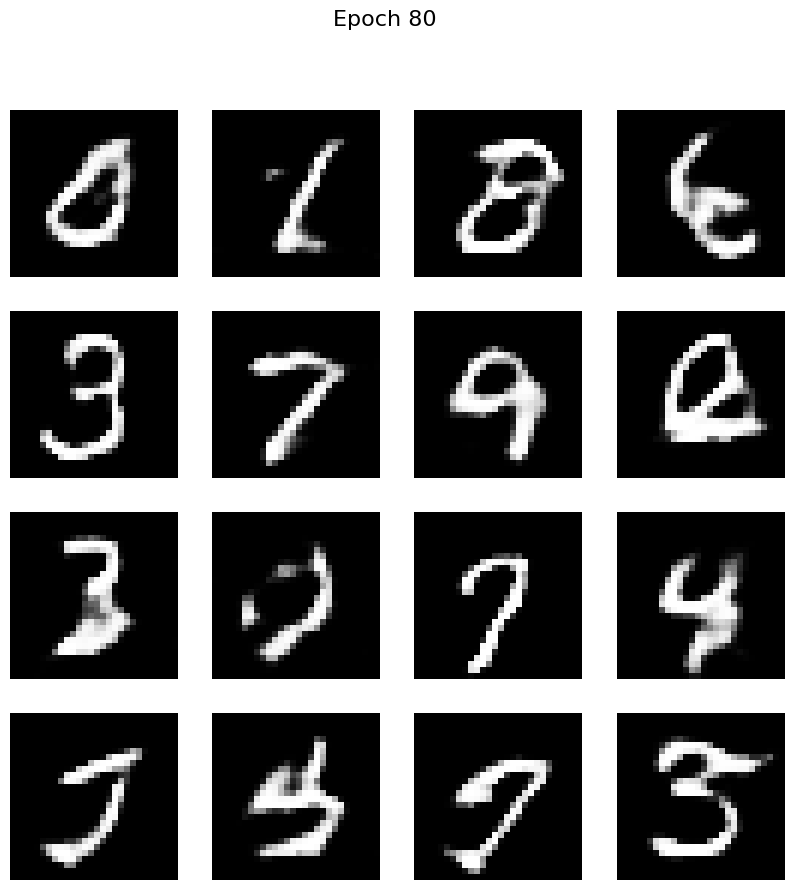

Epoch 81/200 - Generator Loss: 0.9586, Discriminator Loss: 1.2339
Epoch 82/200 - Generator Loss: 0.9269, Discriminator Loss: 1.2408
Epoch 83/200 - Generator Loss: 0.9257, Discriminator Loss: 1.2398
Epoch 84/200 - Generator Loss: 0.9097, Discriminator Loss: 1.2613
Epoch 85/200 - Generator Loss: 0.9204, Discriminator Loss: 1.2427
Epoch 86/200 - Generator Loss: 0.9424, Discriminator Loss: 1.2520
Epoch 87/200 - Generator Loss: 0.9558, Discriminator Loss: 1.2418
Epoch 88/200 - Generator Loss: 0.9470, Discriminator Loss: 1.2279
Epoch 89/200 - Generator Loss: 0.9117, Discriminator Loss: 1.2435
Epoch 90/200 - Generator Loss: 0.9010, Discriminator Loss: 1.2601
Epoch 91/200 - Generator Loss: 0.9185, Discriminator Loss: 1.2381
Epoch 92/200 - Generator Loss: 0.9121, Discriminator Loss: 1.2605
Epoch 93/200 - Generator Loss: 0.9406, Discriminator Loss: 1.2376
Epoch 94/200 - Generator Loss: 0.9594, Discriminator Loss: 1.2533
Epoch 95/200 - Generator Loss: 0.9563, Discriminator Loss: 1.2436
Epoch 96/2

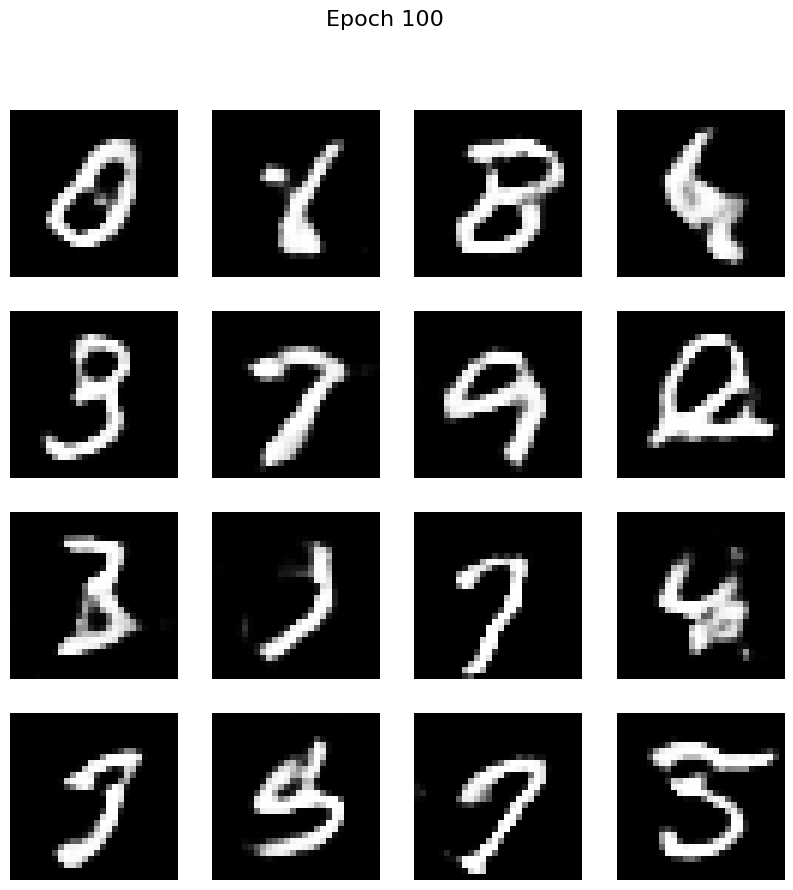

Epoch 101/200 - Generator Loss: 0.9390, Discriminator Loss: 1.2469
Epoch 102/200 - Generator Loss: 0.9374, Discriminator Loss: 1.2423
Epoch 103/200 - Generator Loss: 0.9353, Discriminator Loss: 1.2454
Epoch 104/200 - Generator Loss: 0.9432, Discriminator Loss: 1.2406
Epoch 105/200 - Generator Loss: 0.9619, Discriminator Loss: 1.2375
Epoch 106/200 - Generator Loss: 0.9284, Discriminator Loss: 1.2371
Epoch 107/200 - Generator Loss: 0.9207, Discriminator Loss: 1.2421
Epoch 108/200 - Generator Loss: 0.9173, Discriminator Loss: 1.2467
Epoch 109/200 - Generator Loss: 0.9139, Discriminator Loss: 1.2491
Epoch 110/200 - Generator Loss: 0.8981, Discriminator Loss: 1.2618
Epoch 111/200 - Generator Loss: 0.9158, Discriminator Loss: 1.2433
Epoch 112/200 - Generator Loss: 0.9116, Discriminator Loss: 1.2543
Epoch 113/200 - Generator Loss: 0.9463, Discriminator Loss: 1.2530
Epoch 114/200 - Generator Loss: 0.9570, Discriminator Loss: 1.2390
Epoch 115/200 - Generator Loss: 0.9381, Discriminator Loss: 1.

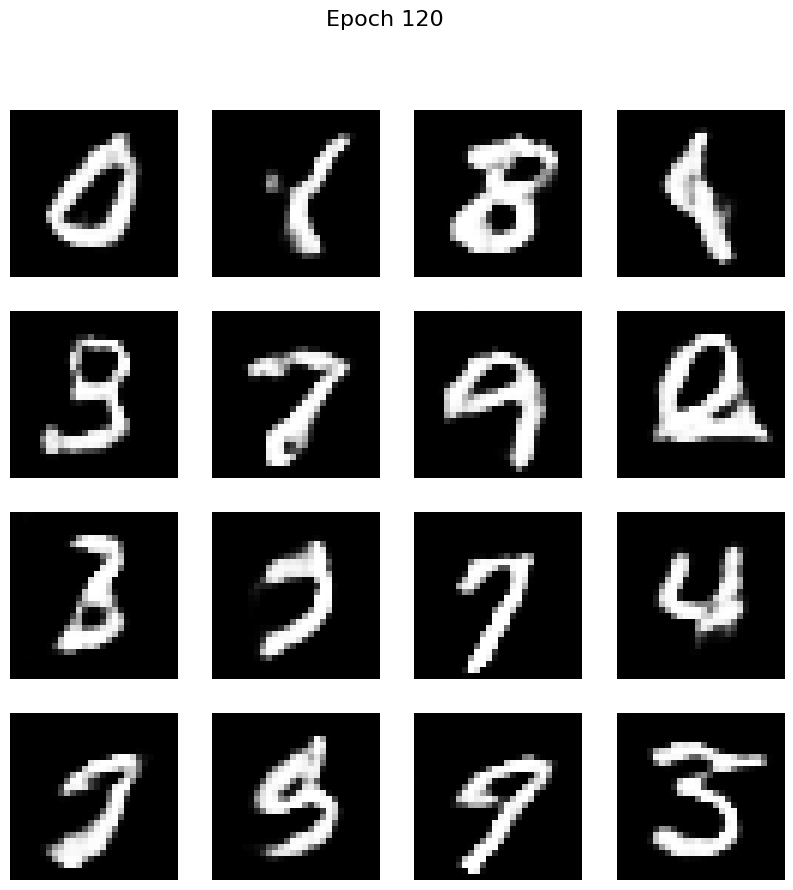

Epoch 121/200 - Generator Loss: 0.9486, Discriminator Loss: 1.2317
Epoch 122/200 - Generator Loss: 0.9382, Discriminator Loss: 1.2394
Epoch 123/200 - Generator Loss: 0.9199, Discriminator Loss: 1.2668
Epoch 124/200 - Generator Loss: 0.9308, Discriminator Loss: 1.2474
Epoch 125/200 - Generator Loss: 0.9590, Discriminator Loss: 1.2375
Epoch 126/200 - Generator Loss: 0.9377, Discriminator Loss: 1.2482
Epoch 127/200 - Generator Loss: 0.9117, Discriminator Loss: 1.2601
Epoch 128/200 - Generator Loss: 0.9200, Discriminator Loss: 1.2539
Epoch 129/200 - Generator Loss: 0.9328, Discriminator Loss: 1.2327
Epoch 130/200 - Generator Loss: 0.9244, Discriminator Loss: 1.2485
Epoch 131/200 - Generator Loss: 0.9113, Discriminator Loss: 1.2594
Epoch 132/200 - Generator Loss: 0.9056, Discriminator Loss: 1.2516
Epoch 133/200 - Generator Loss: 0.9159, Discriminator Loss: 1.2558
Epoch 134/200 - Generator Loss: 0.9224, Discriminator Loss: 1.2503
Epoch 135/200 - Generator Loss: 0.9005, Discriminator Loss: 1.

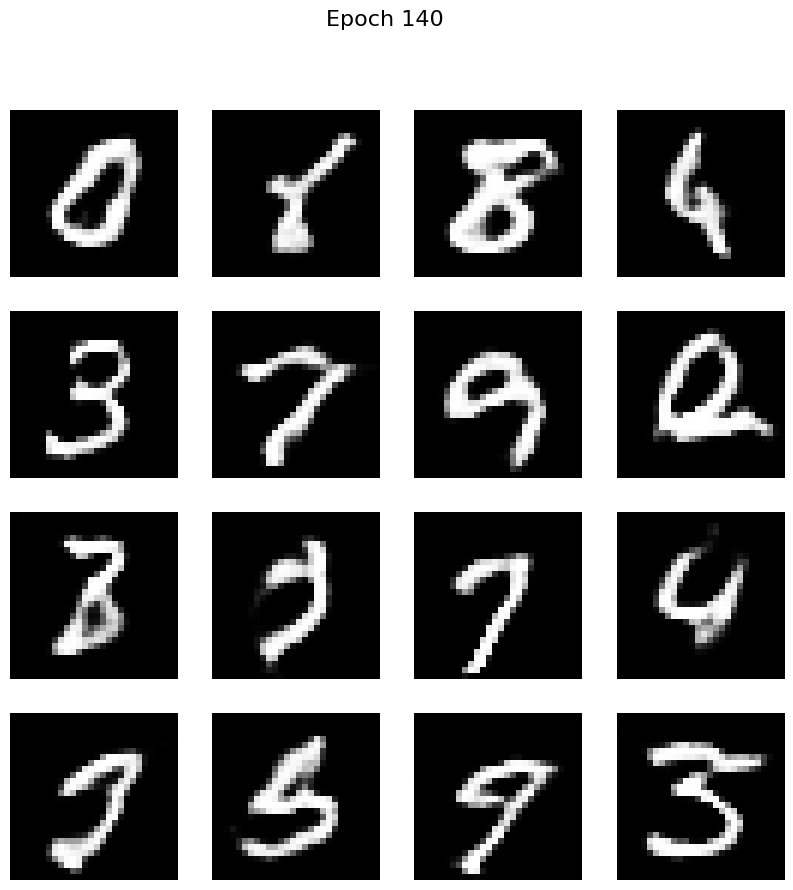

Epoch 141/200 - Generator Loss: 0.8918, Discriminator Loss: 1.2695
Epoch 142/200 - Generator Loss: 0.9131, Discriminator Loss: 1.2505
Epoch 143/200 - Generator Loss: 0.9024, Discriminator Loss: 1.2660
Epoch 144/200 - Generator Loss: 0.9047, Discriminator Loss: 1.2648
Epoch 145/200 - Generator Loss: 0.9050, Discriminator Loss: 1.2624
Epoch 146/200 - Generator Loss: 0.9263, Discriminator Loss: 1.2656
Epoch 147/200 - Generator Loss: 0.9096, Discriminator Loss: 1.2571
Epoch 148/200 - Generator Loss: 0.9071, Discriminator Loss: 1.2679
Epoch 149/200 - Generator Loss: 0.9133, Discriminator Loss: 1.2592
Epoch 150/200 - Generator Loss: 0.9054, Discriminator Loss: 1.2656
Epoch 151/200 - Generator Loss: 0.9046, Discriminator Loss: 1.2613
Epoch 152/200 - Generator Loss: 0.8905, Discriminator Loss: 1.2682
Epoch 153/200 - Generator Loss: 0.9200, Discriminator Loss: 1.2627
Epoch 154/200 - Generator Loss: 0.9163, Discriminator Loss: 1.2674
Epoch 155/200 - Generator Loss: 0.9087, Discriminator Loss: 1.

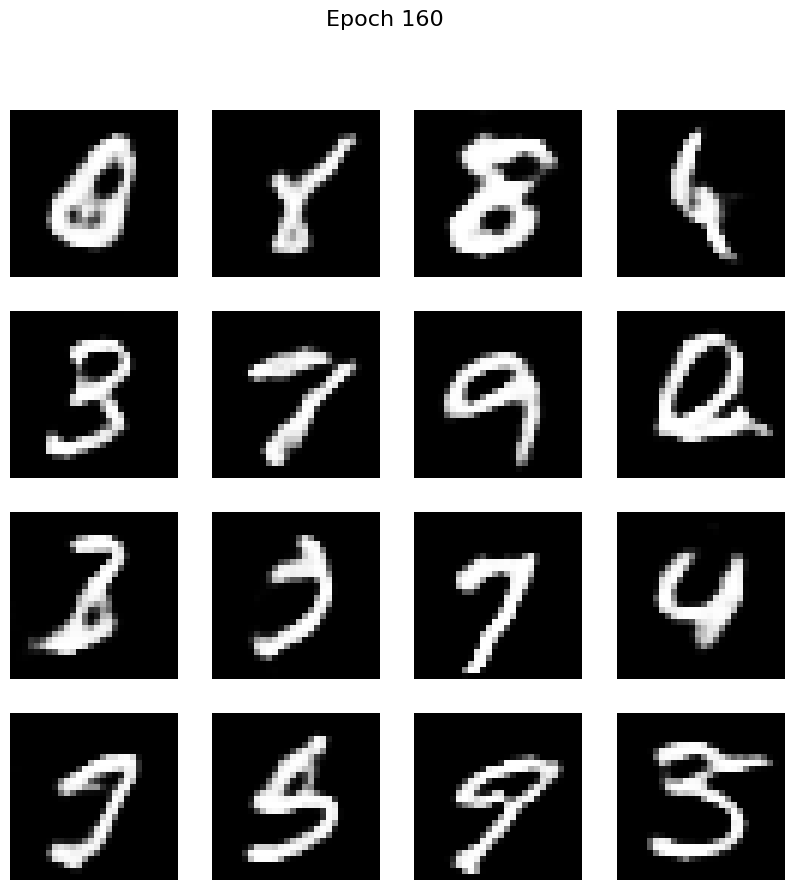

Epoch 161/200 - Generator Loss: 0.9119, Discriminator Loss: 1.2803
Epoch 162/200 - Generator Loss: 0.9189, Discriminator Loss: 1.2568
Epoch 163/200 - Generator Loss: 0.8902, Discriminator Loss: 1.2702
Epoch 164/200 - Generator Loss: 0.9021, Discriminator Loss: 1.2654
Epoch 165/200 - Generator Loss: 0.8893, Discriminator Loss: 1.2672
Epoch 166/200 - Generator Loss: 0.8921, Discriminator Loss: 1.2714
Epoch 167/200 - Generator Loss: 0.8957, Discriminator Loss: 1.2621
Epoch 168/200 - Generator Loss: 0.8806, Discriminator Loss: 1.2754
Epoch 169/200 - Generator Loss: 0.8803, Discriminator Loss: 1.2755
Epoch 170/200 - Generator Loss: 0.9034, Discriminator Loss: 1.2743
Epoch 171/200 - Generator Loss: 0.8885, Discriminator Loss: 1.2708
Epoch 172/200 - Generator Loss: 0.8871, Discriminator Loss: 1.2751
Epoch 173/200 - Generator Loss: 0.9466, Discriminator Loss: 1.2635
Epoch 174/200 - Generator Loss: 0.9336, Discriminator Loss: 1.2515
Epoch 175/200 - Generator Loss: 0.9222, Discriminator Loss: 1.

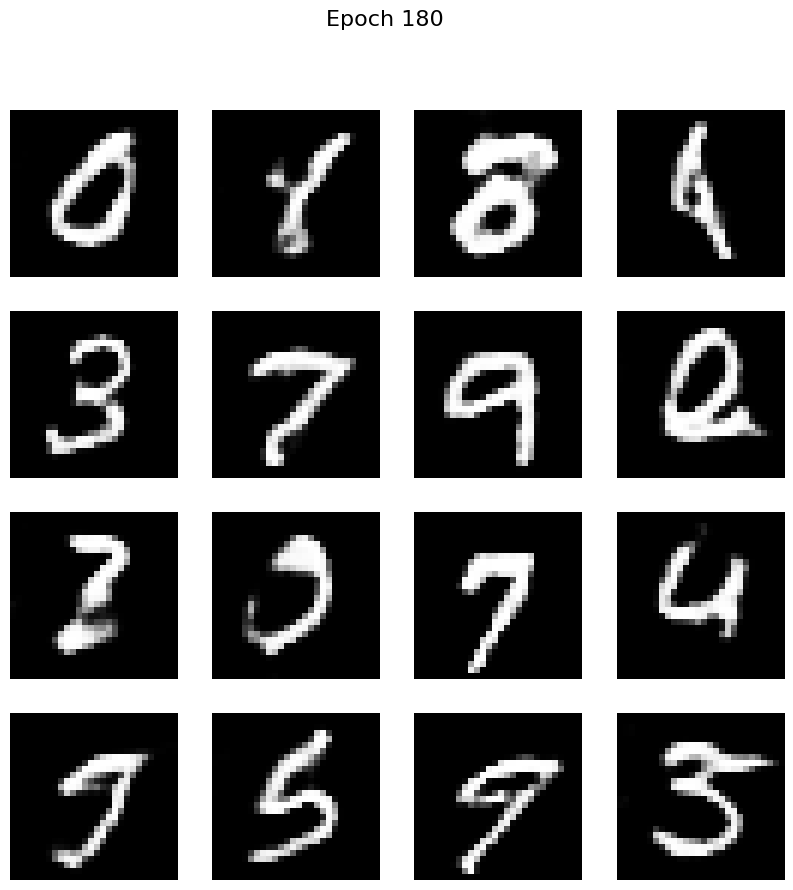

Epoch 181/200 - Generator Loss: 0.8954, Discriminator Loss: 1.2752
Epoch 182/200 - Generator Loss: 0.8943, Discriminator Loss: 1.2685
Epoch 183/200 - Generator Loss: 0.8852, Discriminator Loss: 1.2822
Epoch 184/200 - Generator Loss: 0.8914, Discriminator Loss: 1.2675
Epoch 185/200 - Generator Loss: 0.8773, Discriminator Loss: 1.2757
Epoch 186/200 - Generator Loss: 0.8864, Discriminator Loss: 1.2696
Epoch 187/200 - Generator Loss: 0.8679, Discriminator Loss: 1.2919
Epoch 188/200 - Generator Loss: 0.8892, Discriminator Loss: 1.2742
Epoch 189/200 - Generator Loss: 0.9138, Discriminator Loss: 1.2643
Epoch 190/200 - Generator Loss: 0.8830, Discriminator Loss: 1.2797
Epoch 191/200 - Generator Loss: 0.8885, Discriminator Loss: 1.2714
Epoch 192/200 - Generator Loss: 0.8752, Discriminator Loss: 1.2855
Epoch 193/200 - Generator Loss: 0.8915, Discriminator Loss: 1.2725
Epoch 194/200 - Generator Loss: 0.8920, Discriminator Loss: 1.2706
Epoch 195/200 - Generator Loss: 0.8853, Discriminator Loss: 1.

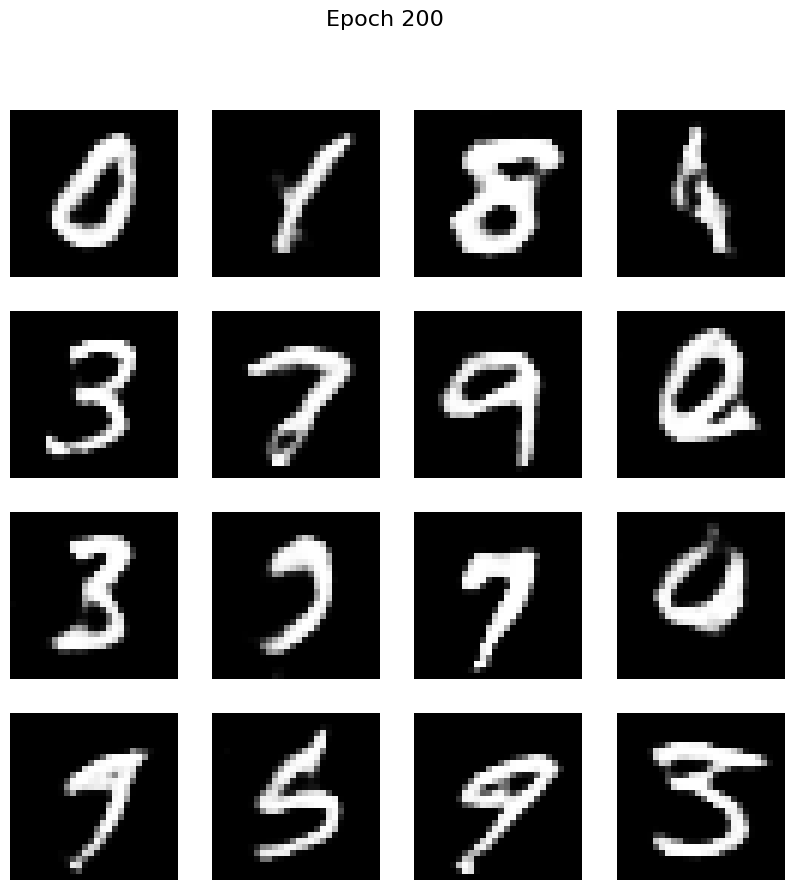


--- Training complete. Generating final images. ---


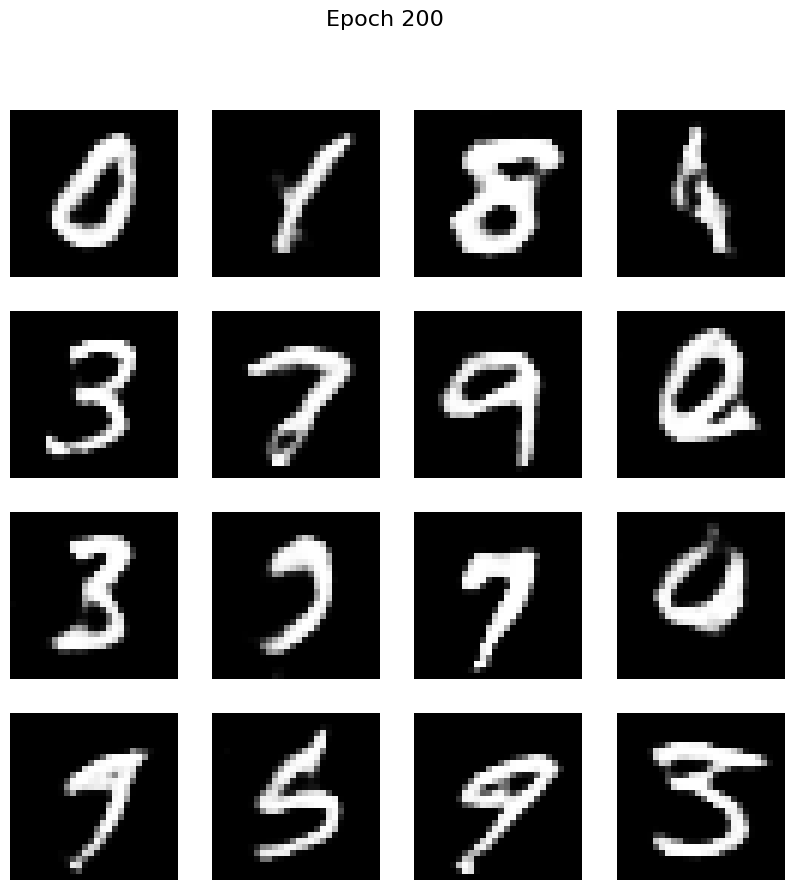

In [ ]:
# 5. The Main Training Loop
def train(dataset, epochs):
    print("\n--- Beginning GAN Training ---")

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        for image_batch in dataset:
            # Perform one training step
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())

        # Calculate average loss for the epoch
        avg_gen_loss = np.mean(gen_loss_list)
        avg_disc_loss = np.mean(disc_loss_list)

        # Print progress every epoch
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.4f}, "
              f"Discriminator Loss: {avg_disc_loss:.4f}")

        # Generate and save images every 20 epochs
        if (epoch + 1) % 20 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    # Generate one final set of images at the end of training
    print("\n--- Training complete. Generating final images. ---")
    generate_and_save_images(generator, epochs, seed)

# Run the training process
train(train_dataset, EPOCHS)